# Fault Detection in Wastewater Treatment Plants: Application of Autoencoders with Streaming Data

### Notebook developed to implement the fault detection system described in the paper *Fault Detection in Wastewater Treatment Plants: Application of Autoencoders with Streaming Data*

## LSTM - Case 3

### Data obtained with the BSM2 simulator.

In [ ]:
# Load libraries needed by the projec
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timezone
import statsmodels.api as sm
import scipy.stats as st
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.models import load_model
%matplotlib inline

from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load dataset
df1 = pd.read_excel('/content/drive/MyDrive/Autoencoder/datasets/DO_falha3.xlsx')

df_normal = pd.read_csv('/content/drive/MyDrive/Autoencoder/datasets/sensor_DO_normal.csv', sep=';')

In [ ]:
df1.head()

,time,value
0,0.000000,0.244862
1,0.010417,2.766354
2,0.020833,1.801208
3,0.031250,2.127110
4,0.041667,1.963473


In [ ]:
df = pd.DataFrame()
df['Date'] = df1.time
df['value'] = df1.value

In [ ]:
df_normal1 = pd.DataFrame()
df_normal1['Date'] = df_normal.time
df_normal1['value'] = df_normal.value

In [ ]:
df_normal1.head()

,Date,value
0,0.000000,0.244862
1,0.010417,2.766354
2,0.020833,1.801208
3,0.031250,2.127110
4,0.041667,1.963473


In [ ]:
# Adjust stuck anomaly value
# Check indices of anomalous samples
df1.loc[df1['time'] == 95]

# Adjust Drift Values

index1 = df.index[df['Date']>=40].tolist()
index2 = df.index[df['Date']<=43].tolist()
max(index2)
min(index1)
# print(df.loc[df['Date'] == 58])
# print(df.loc[df['Date'] == 62])
for i in range(1440,1632):
  df.loc[i,'value'] = df.loc[i,'value']+0.5

In [ ]:
# Adjust Drift Values

#index1 = df.index[df['Date']>=40].tolist()
#index2 = df.index[df['Date']<=43].tolist()
#max(index2)
#min(index1)
for i in range(5568,5952):
  df.loc[i,'value'] = df.loc[i,'value']-27

In [ ]:
print(df.loc[df['Date'] == 15])
print(df.loc[df['Date'] == 17])

      Date  value
1440  15.0    2.5
      Date     value
1632  17.0  1.066578


## Data processing

### Split dataset into training and testing sets

In [ ]:
df1_treino = df_normal1.iloc[0:10000,:]
df1_teste = df.iloc[0:10000,:]

In [ ]:
df1_treino.to_csv('df_treino_bsm2.csv')
# Using time as an index
df1_treino = pd.read_csv('df_treino_bsm2.csv', parse_dates=True, index_col="Date")
# Delete column created with old indexes
df1_treino = df1_treino.drop(columns=['Unnamed: 0'])
df1_treino.head()

,value
Date,
0.000000,0.244862
0.010417,2.766354
0.020833,1.801208
0.031250,2.127110
0.041667,1.963473


## Implementing Autoencoders

In [ ]:
# Normalizing the datas
training1_mean = df1_treino.mean()
training1_std = df1_treino.std()
df1_training_value = (df1_treino - training1_mean) / training1_std
print("Number of training samples:", len(df1_training_value))  

Number of training samples: 10000


In [ ]:
# Create the window that will go through the sequence
TIME_STEPS = 96

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df1_training_value.values) 

In [ ]:
# load trained model
model = load_model('/content/drive/MyDrive/Autoencoder/modelos/model_1_autoencoder_LSTM.h5')

In [ ]:
threshold = 1.05
#1.11052173350439

In [ ]:
df1_teste.to_csv('df_teste_bsm2.csv')
# Using time as an index
df1_teste = pd.read_csv('df_teste_bsm2.csv', parse_dates=True, index_col="Date")
# Delete column created with old indexes
df1_teste = df1_teste.drop(columns=['Unnamed: 0'])

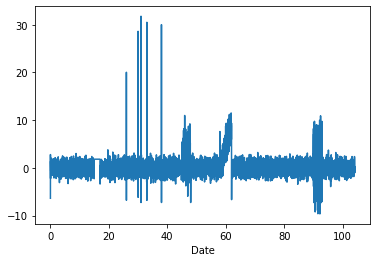

Test input shape:  (9904, 96, 1)


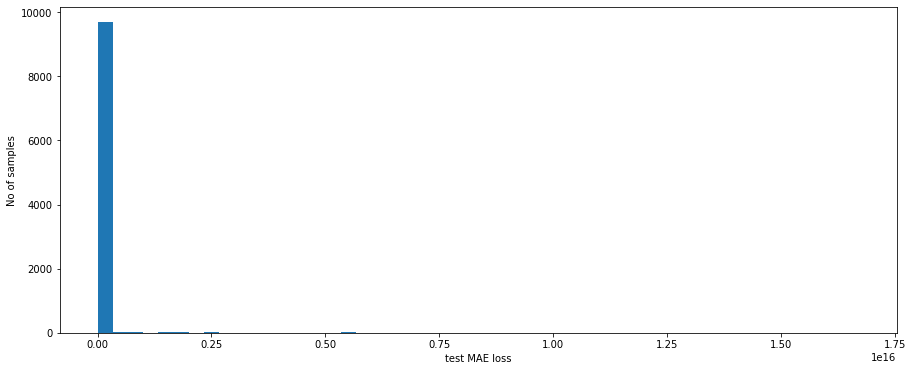

Number of anomaly samples:  1899
Indices of anomaly samples:  (array([1370, 1371, 1372, ..., 8920, 8921, 8922]),)


In [ ]:
df_test_value = (df1_teste - training1_mean) / training1_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
plt.figure(figsize = (15, 6))
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
# Anomalous values
df_subset = df1_teste.iloc[anomalous_data_indices] # Valores anomalos

In [ ]:
# Create column with indexes to facilitate plots
df_subset['id2'] = df_subset.index
df1_teste['id1'] = df1_teste.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Results

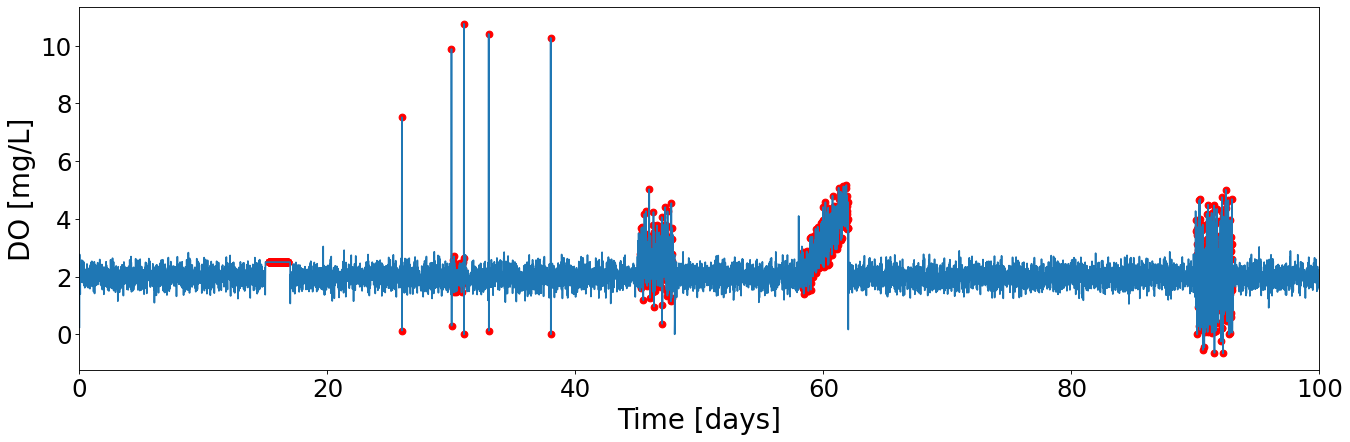

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.scatter(df_subset.id2,df_subset.value, color="r")
plt.plot(df1_teste.id1, df1_teste.value)
plt.xlim(0,100)
plt.savefig('/content/drive/MyDrive/Autoencoder/resultado_total_lstm3.pdf', dpi=500, format='pdf', bbox_inches='tight')

## Graph with individual results

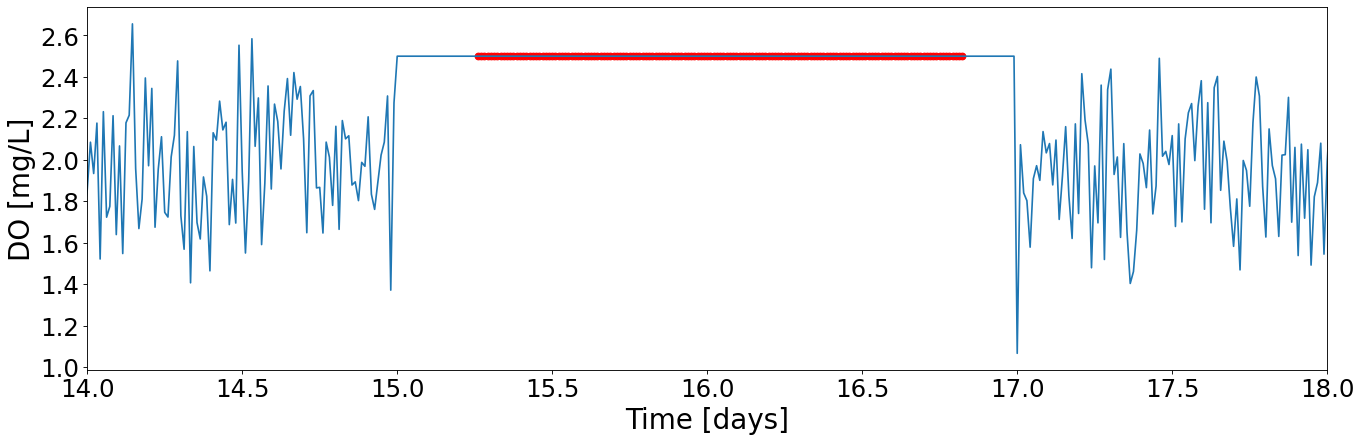

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[0:151],df_subset.value.iloc[0:151], color="r")
plt.plot(df1_teste.id1.iloc[1340:1732], df1_teste.value.iloc[1340:1732])
plt.xlim(14,18)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_lstm_3/resultado_stuck3_lstm.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 15].head(3) # 15.260417

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 15].head(1) #15.0

# Do the math for the fraction that equals 15 min.
((15.260417 - 15.0)*15)/0.010416666666666666 # 375.0004800000005

375.0004800000005

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 15 and i <= 17:
    cont = cont+1
print('Nº de anomalias para a falha Stuck: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 15 and i <= 17:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Stuck: ',cont2)

Nº de anomalias para a falha Stuck:  151
Nº de amostras totais para a falha Stuck:  193


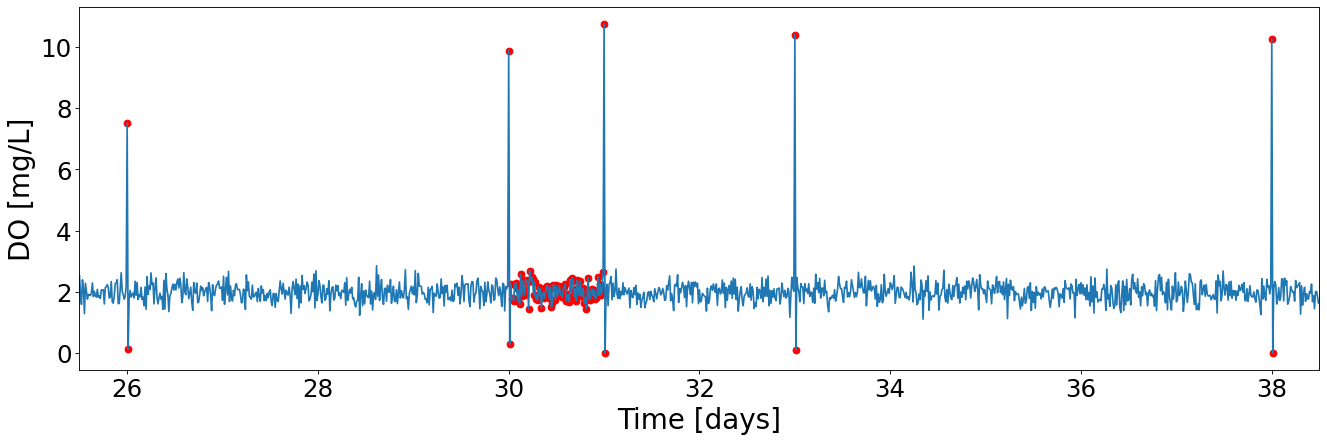

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[151:255],df_subset.value.iloc[151:255], color="r")
plt.plot(df1_teste.id1.iloc[2396:3748], df1_teste.value.iloc[2396:3748])
plt.xlim(25.5,38.5)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_lstm_3/resultado_spike3_lstm.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 26 and i <= 38:
    cont = cont+1
print('Nº de anomalias para a falha Stuck: ',cont)

Nº de anomalias para a falha Stuck:  103


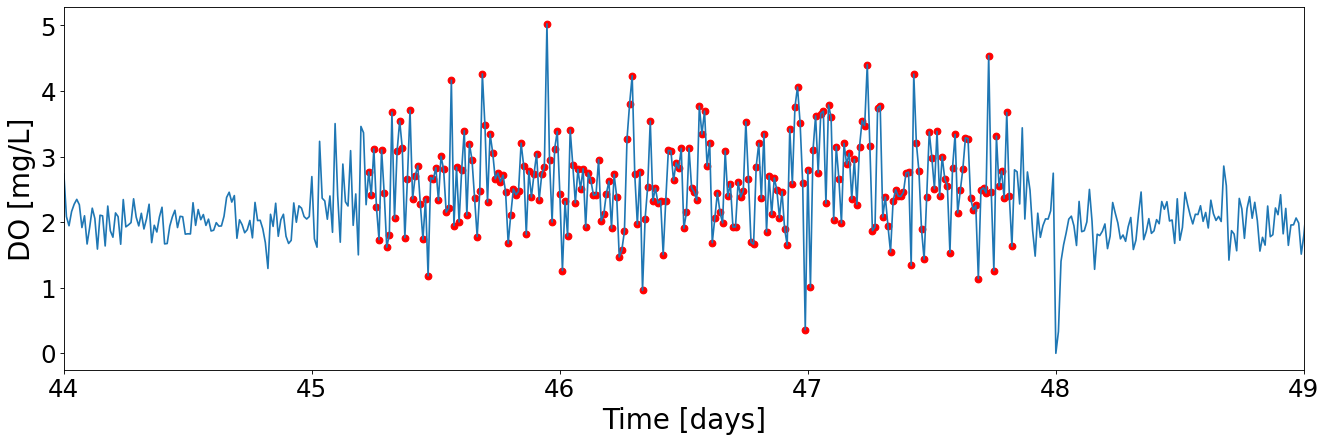

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[255:505],df_subset.value.iloc[255:505], color="r")
plt.plot(df1_teste.id1.iloc[4220:4708], df1_teste.value.iloc[4220:4708])
plt.xlim(44,49)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_lstm_3/resultado_bias3_lstm.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
df_subset.loc[df_subset['id2'] >= 45].head(1) # 45.229167

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 45].head(1) #45.0

# Do the math for the fraction that equals 15 min.
((45.229167 - 45.0)*15)/0.010416666666666666 # 330.0004799999954

330.0004799999954

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 45 and i <= 48:
    cont = cont + 1
print('Nº de anomalias para a falha Degradation: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 45 and i <= 48:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Degradation: ',cont2)

Nº de anomalias para a falha Degradation:  250
Nº de amostras totais para a falha Degradation:  289


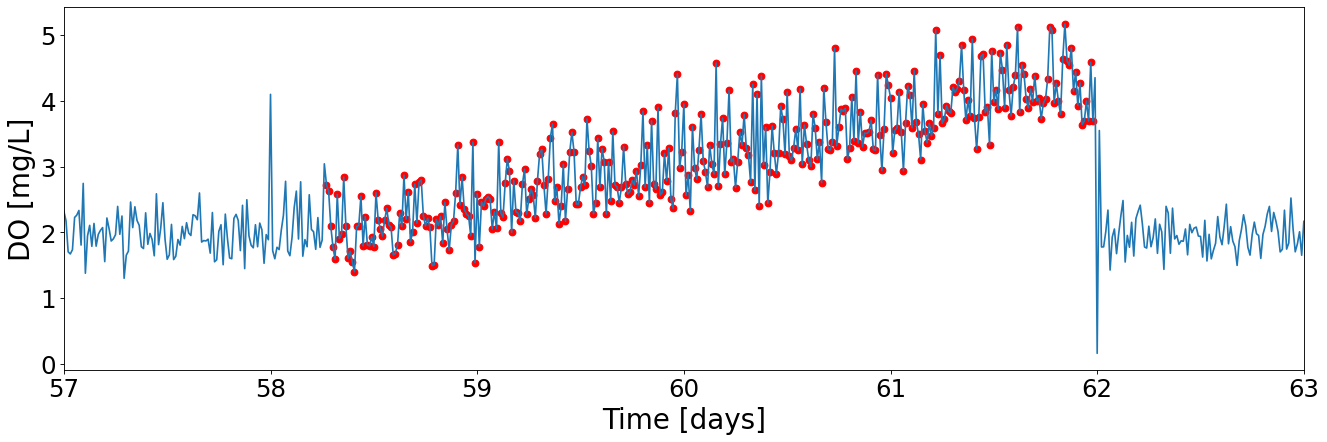

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[505:862],df_subset.value.iloc[505:862], color="r")
plt.plot(df1_teste.id1.iloc[5468:6052], df1_teste.value.iloc[5468:6052])
plt.xlim(57,63)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_lstm_3/resultado_drift3_lstm.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
df_subset.loc[df_subset['id2'] >= 58].head(1) # 58.270833

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 58].head(1) #58.0

# Do the math for the fraction that equals 15 min.
((58.270833 - 58.0)*15)/0.010416666666666666 # 389.9995200000046

389.9995200000046

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 58 and i <= 62:
    cont = cont + 1
print('Nº de anomalias para a falha Degradation: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 58 and i <= 62:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Degradation: ',cont2)

Nº de anomalias para a falha Degradation:  357
Nº de amostras totais para a falha Degradation:  385


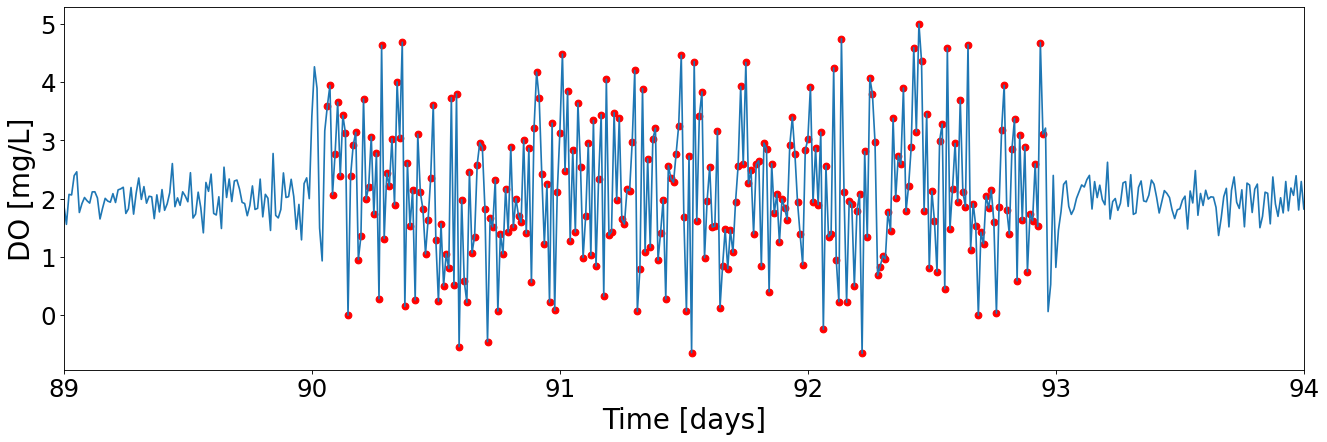

In [ ]:
# Degradation
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[862:1140],df_subset.value.iloc[862:1140], color="r")
plt.plot(df1_teste.id1.iloc[8540:9028], df1_teste.value.iloc[8540:9028])
plt.xlim(89,94)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_lstm_3/resultado_PD3_lstm.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
df_subset.loc[df_subset['id2'] >= 90].head(1) # 90.0625

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 90].head(1) #90.0

# Do the math for the fraction that equals 15 min.
((90.0625 - 90.0)*15)/0.010416666666666666 # 90.0

90.0

In [ ]:
# Count number of anomalies
cont = 0
for i in df_subset['id2']:
  if i >= 90 and i <= 93:
    cont = cont + 1
print('Nº de anomalias para a falha Degradation: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 90 and i <= 93:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Degradation: ',cont2)

Nº de anomalias para a falha Degradation:  278
Nº de amostras totais para a falha Degradation:  289
